<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-LinearRegression" data-toc-modified-id="Модель-LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель LinearRegression</a></span></li><li><span><a href="#Модель-DecisionTreeRegressor" data-toc-modified-id="Модель-DecisionTreeRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель DecisionTreeRegressor</a></span></li><li><span><a href="#Модель-CatBoostRegressor" data-toc-modified-id="Модель-CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель CatBoostRegressor</a></span></li><li><span><a href="#Модель-LGBMRegressor" data-toc-modified-id="Модель-LGBMRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Модель LGBMRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
pip install -q catboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -q lightgbm

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

RND = 1 #для фиксации рандомайзера(random_state=RND)

In [4]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0]) 

In [5]:
display(df.index.is_monotonic)
display(df.head(10))
df.info()

True

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
print(df.index.max() - df.index.min())
print(df.isna().sum())
df.describe()

183 days 23:50:00
num_orders    0
dtype: int64


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Проверили и увидели, что даты расположены в хронологичном порядке. Также по данным увидели, что у нас есть информмация с 1 марта 2018 года по 31 августа 2018 года, всего 183дня 23часа. В датасете два столбца: datetime — дата и время заказа такси, num_orders — количество заказов такси(целевой признак) типа int64. Количество строк в датасете = 4416. Пропусков нету.

## Анализ

Сделаем ресемплирование с сумой заказов на каждый час, посмотрим график

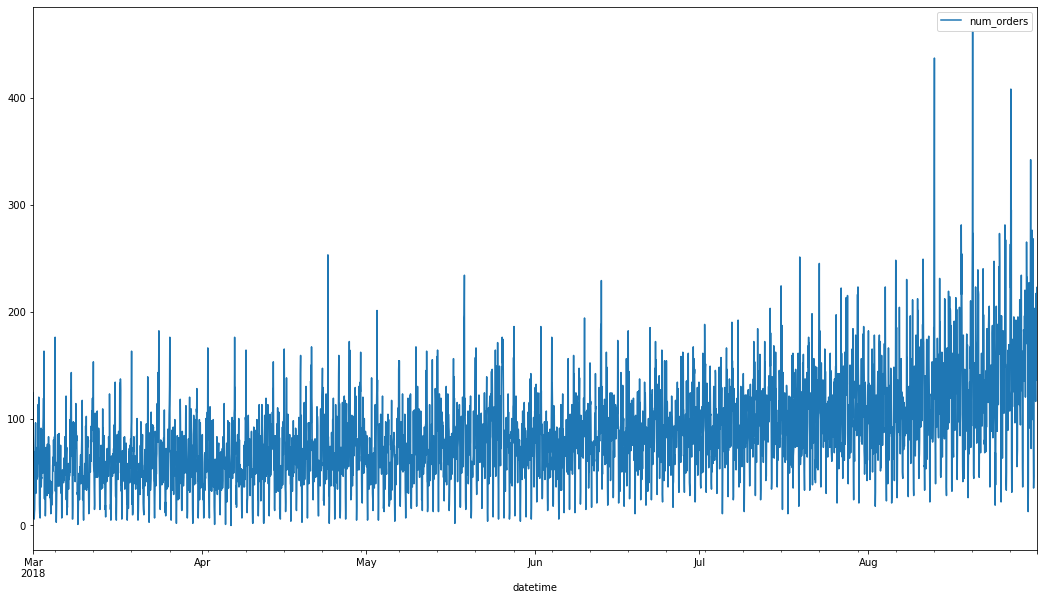

In [7]:
# Построим график с разбивкой по часу
df = df.resample('1H').sum()
figsize = (18, 10)
df.plot(figsize=figsize)
plt.show()

Очень много данных сложно рассмотреть, поэтому посмотрим на данные за последние 7 дней

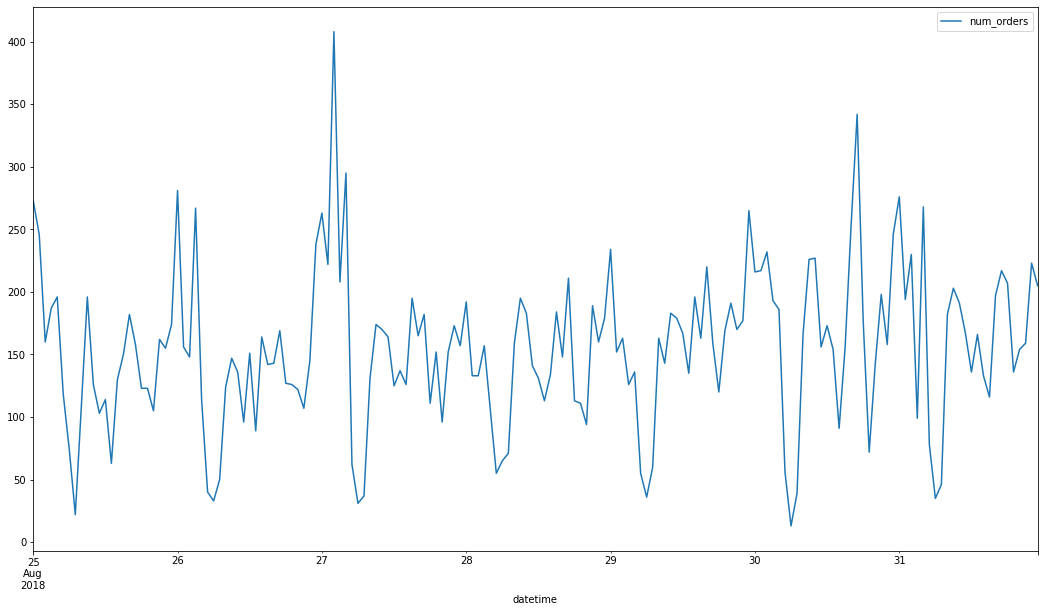

In [8]:
df['2018-08-25':'2018-08-31'].plot(figsize=figsize)
plt.show()

Посмотрим на график трендов, сезонности, остатков(шум) декомпозиции заказов такси

In [9]:
decomposed = seasonal_decompose(df)

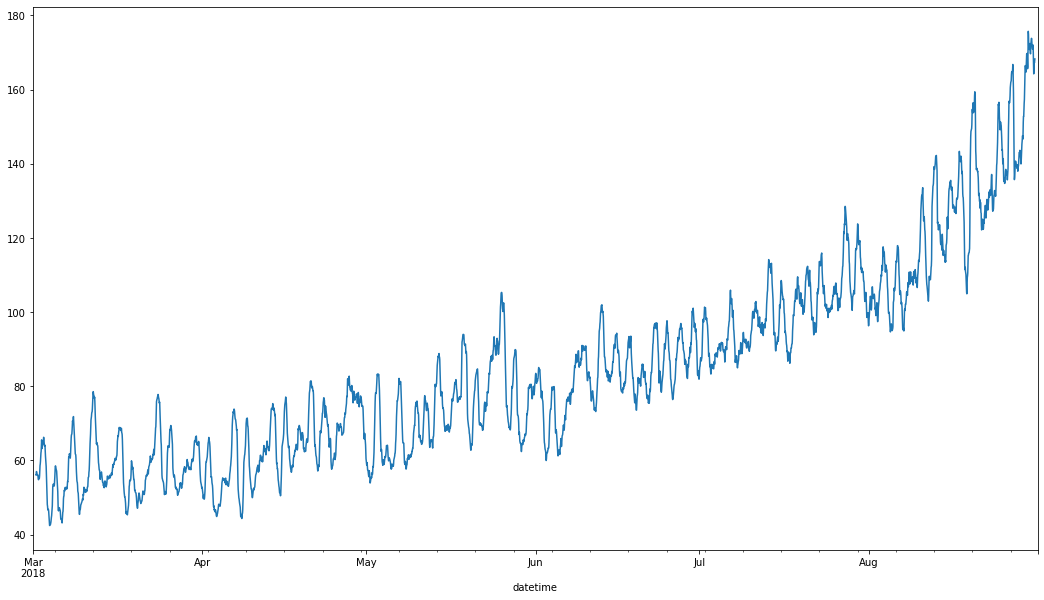

In [10]:
#тренд
decomposed.trend.plot(figsize=figsize)
plt.show()

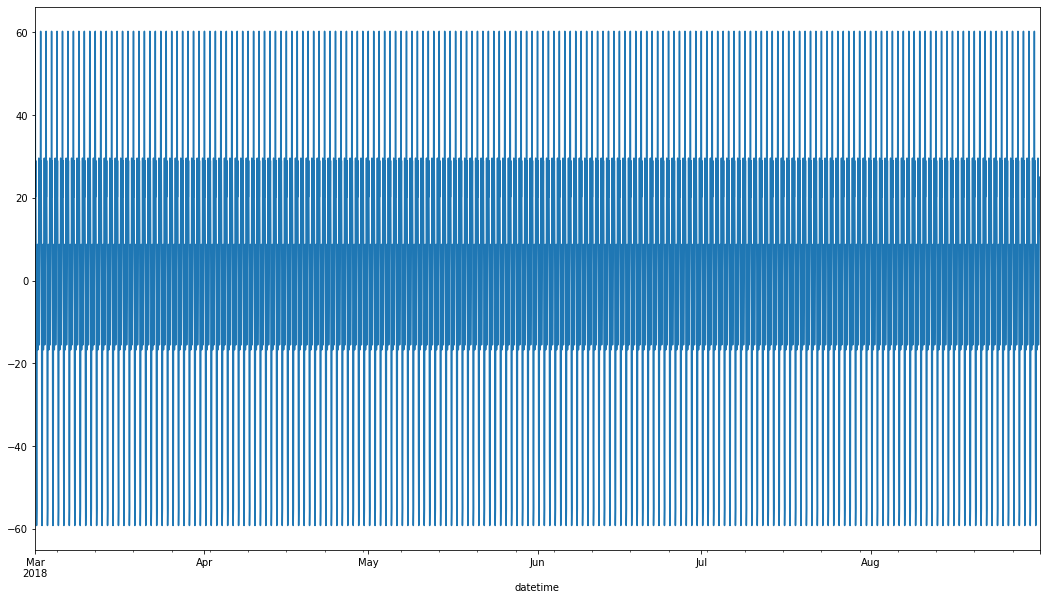

In [11]:
#сезонная составляющая
decomposed.seasonal.plot(figsize=figsize)
plt.show()

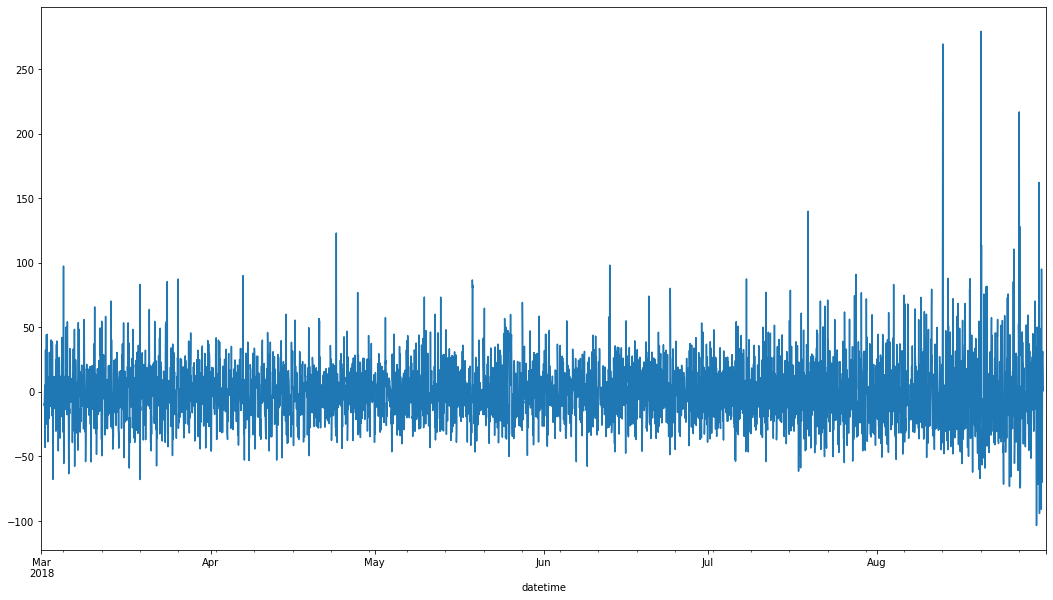

In [12]:
#остаток декомпозици(шум)
decomposed.resid.plot(figsize=figsize)
plt.show()

Опять много данных ничего не видно, поэтому посмотрим на том же промежутке, который брали для ресемплирования

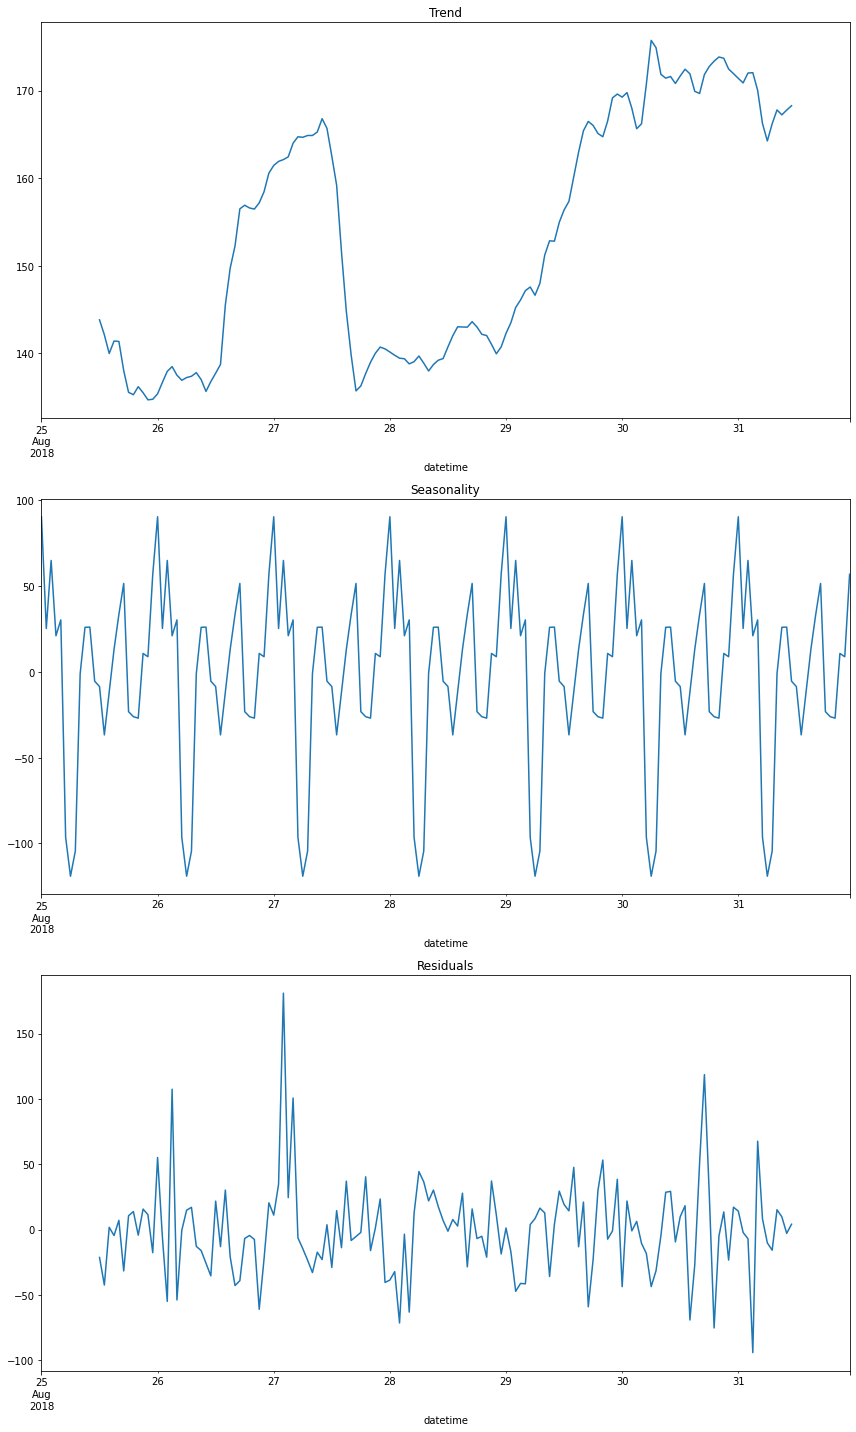

In [13]:
decomposed_part = seasonal_decompose(df['2018-08-25':'2018-08-31'])

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed_part.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed_part.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed_part.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Видно, что тренд растет(среднее значение увеличивается, т.е. кол-во заказов увеличивается в определенные моменты времени), ночью кол-во заказов меньше всего, под вечер становится час пик. Временной ряд не является стационарным, так как тренд меняется, его распределение меняется со временем.

Построим график временного ряда

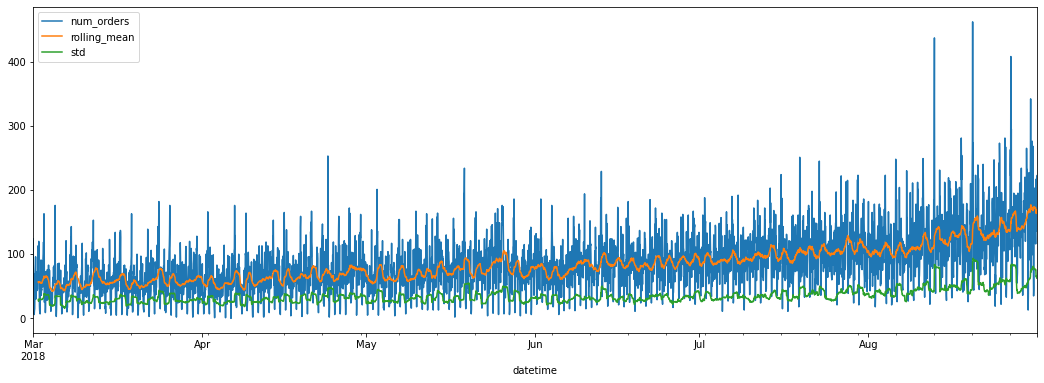

In [14]:
df_plot = df.copy()
df_plot['rolling_mean'] = df_plot.rolling(24).mean()
df_plot['std'] = df_plot['num_orders'].rolling(24).std()
df_plot.plot(figsize=(18, 6))
plt.show()

Построим график разности временного ряда(это график как должен выглядеть станционарный ряд)

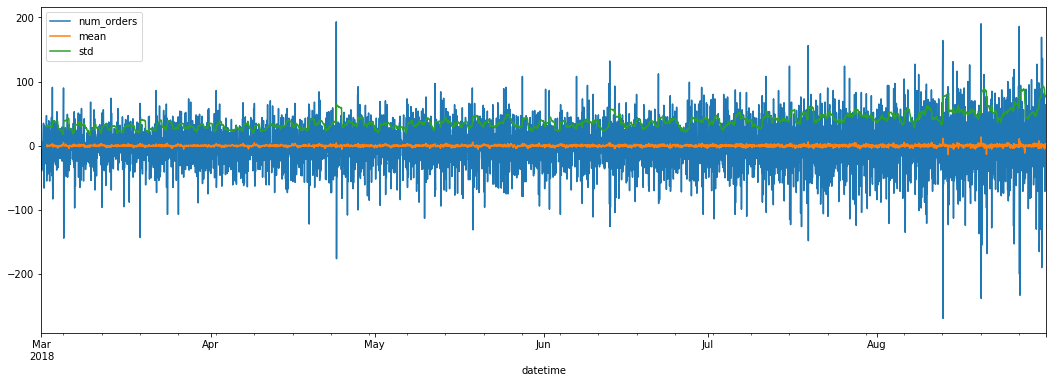

In [15]:
df_shift = df - df.shift()
df_shift['mean'] = df_shift['num_orders'].rolling(24).mean()
df_shift['std'] = df_shift['num_orders'].rolling(24).std()
df_shift.plot(figsize=(18, 6))
plt.show()

**Вывод:**
На графиках явно видна суточная сезонность. Ночью количество заказов стремится к нулю, а вечером самый час пик - момент самого сильного спроса на услуги такси. Наш временной ряд не является стационарным, так как распределение меняется со временем, тренд растет. Также видно, что нету почти зависимости между кол-вом заказов и месяцем, если она и есть небольшая, то это может быть просто связано с увелечением машин в компании в определенные месяца.

## Обучение

Создадим новые признаки

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    dataa = data.copy()
    dataa['dayofweek'] = dataa.index.dayofweek
    dataa['hour'] = dataa.index.hour
    for lag in range(1, max_lag + 1):
        dataa[f'lag_{lag}'] = dataa['num_orders'].shift(lag)

    dataa['rolling_mean'] = dataa['num_orders'].shift().rolling(rolling_mean_size).mean()
    return dataa

### Модель LinearRegression

In [17]:
%%time

lin_best_lag = 0
lin_best_roll_size = 0
best_rmse = 48
lin_features_train = None
lin_target_train = None
lin_features_test = None
lin_target_test = None

for lag in [24, 48, 72, 96, 120, 144, 168]:
    for roll_mean_size in [24, 48, 72, 96, 120, 144, 168]:
        df_lin = make_features(df, lag, roll_mean_size).dropna()
        features = df_lin.drop(['num_orders'], axis=1)
        target = df_lin['num_orders']
        features_train, features_test, target_train, target_test = train_test_split(features, target, \
        test_size=0.1, shuffle=False, random_state=RND)
        model_lin = LinearRegression()
        tss = TimeSeriesSplit()
        lin_params = {
            'fit_intercept':[True,False],
            'normalize':[True,False],
            'copy_X':[True, False]
            }

        rscv_model_lin = RandomizedSearchCV(model_lin, lin_params, scoring='neg_root_mean_squared_error', cv=tss, \
                                            n_jobs=-1, refit=True)

        rscv_model_lin.fit(features_train, target_train)
        best_model_lin = rscv_model_lin.best_estimator_
        best_params_model_lin = rscv_model_lin.best_params_
        best_score_lin = abs(rscv_model_lin.best_score_)

        if best_score_lin < best_rmse:
            lin_best_lag = lag
            lin_best_roll_size = roll_mean_size
            lin_features_train = features_train
            lin_target_train = target_train
            lin_features_test = features_test
            lin_target_test = target_test
            
print(best_model_lin)

print(f'RMSE лучшей модели LinearRegression на обучающей выборке: {best_score_lin}')
print('--------------------')
print(f'Смещение лучшей модели: {lin_best_lag}')
print('--------------------')
print(f'Скользящее окно лучшей модели: {lin_best_roll_size}')
print('--------------------')
print(f'Гиперпараметры лучшей модели: {best_params_model_lin}')

LinearRegression(normalize=True)
RMSE лучшей модели LinearRegression на обучающей выборке: 22.686529338679772
--------------------
Смещение лучшей модели: 168
--------------------
Скользящее окно лучшей модели: 168
--------------------
Гиперпараметры лучшей модели: {'normalize': True, 'fit_intercept': True, 'copy_X': True}
CPU times: user 2min 34s, sys: 5min 37s, total: 8min 11s
Wall time: 8min 12s


### Модель DecisionTreeRegressor

In [18]:
%%time

tree_best_lag = 0
tree_best_roll_size = 0
best_rmse = 48
tree_features_train = None
tree_target_train = None
tree_features_test = None
tree_target_test = None

for lag in [24, 48, 72, 96, 120, 144, 168]:
    for roll_mean_size in [24, 48, 72, 96, 120, 144, 168]:
        df_tree = make_features(df, lag, roll_mean_size).dropna()
        features_tree = df_tree.drop(['num_orders'], axis=1)
        target_tree = df_tree['num_orders']
        features_train, features_test, target_train, target_test = train_test_split(features_tree, target_tree, \
        test_size=0.1, shuffle=False, random_state=RND)
        model_tree = DecisionTreeRegressor(random_state=RND)
        tss = TimeSeriesSplit()
        tree_params = {
            'max_depth': range(1, 10),
            'min_samples_leaf': range(1, 10)
            }

        rscv_model_tree = RandomizedSearchCV(model_tree, tree_params, scoring='neg_root_mean_squared_error', cv=tss, \
                                            n_jobs=-1, refit=True, random_state=RND)

        rscv_model_tree.fit(features_train, target_train)
        best_model_tree = rscv_model_tree.best_estimator_
        best_params_model_tree = rscv_model_tree.best_params_
        best_score_tree = abs(rscv_model_tree.best_score_)

        if best_score_tree < best_rmse:
            tree_best_lag = lag
            tree_best_roll_size = roll_mean_size
            tree_features_train = features_train
            tree_target_train = target_train
            tree_features_test = features_test
            tree_target_test = target_test
            
print(best_model_tree)

print(f'RMSE лучшей модели DecisionTreeRegressor на обучающей выборке: {best_score_tree}')
print('--------------------')
print(f'Смещение лучшей модели: {tree_best_lag}')
print('--------------------')
print(f'Скользящее окно лучшей модели: {tree_best_roll_size}')
print('--------------------')
print(f'Гиперпараметры лучшей модели: {best_params_model_tree}')

DecisionTreeRegressor(max_depth=4, min_samples_leaf=5, random_state=1)
RMSE лучшей модели DecisionTreeRegressor на обучающей выборке: 27.06406857930032
--------------------
Смещение лучшей модели: 168
--------------------
Скользящее окно лучшей модели: 168
--------------------
Гиперпараметры лучшей модели: {'min_samples_leaf': 5, 'max_depth': 4}
CPU times: user 2min 45s, sys: 6.82 s, total: 2min 52s
Wall time: 2min 52s


### Модель CatBoostRegressor

In [19]:
%%time

cat_best_lag = 0
cat_best_roll_size = 0
best_rmse = 48
cat_features_train = None
cat_target_train = None
cat_features_test = None
cat_target_test = None

for lag in [24, 48, 72, 96, 120, 144, 168]:
    for roll_mean_size in [24, 48, 72, 96, 120, 144, 168]:
        df_cat = make_features(df, lag, roll_mean_size).dropna()
        features_cat = df_cat.drop(['num_orders'], axis=1)
        target_cat = df_cat['num_orders']
        features_train, features_test, target_train, target_test = train_test_split(features_cat, target_cat, \
        test_size=0.1, shuffle=False, random_state=RND)
        model_cat = CatBoostRegressor(logging_level = 'Silent')
        tss = TimeSeriesSplit()
        params_cat = {
            'depth': [10, 20] ,  
            'n_estimators': [10, 20]  
            }

        rscv_model_cat = RandomizedSearchCV(model_cat, params_cat, scoring='neg_root_mean_squared_error', cv=tss, \
                                            n_jobs=-1, refit=True, random_state=RND)

        rscv_model_cat.fit(features_train, target_train)
        best_model_cat = rscv_model_cat.best_estimator_
        best_params_model_cat = rscv_model_cat.best_params_
        best_score_cat = abs(rscv_model_cat.best_score_)

        if best_score_cat < best_rmse:
            cat_best_lag = lag
            cat_best_roll_size = roll_mean_size
            cat_features_train = features_train
            cat_target_train = target_train
            cat_features_test = features_test
            cat_target_test = target_test
            
print(best_model_cat)

print(f'RMSE лучшей модели CatBoostRegressor на обучающей выборке: {best_score_cat}')
print('--------------------')
print(f'Смещение лучшей модели: {cat_best_lag}')
print('--------------------')
print(f'Скользящее окно лучшей модели: {cat_best_roll_size}')
print('--------------------')
print(f'Гиперпараметры лучшей модели: {best_params_model_cat}')

RMSE лучшей модели CatBoostRegressor на обучающей выборке: 25.0256453929147
--------------------
Смещение лучшей модели: 168
--------------------
Скользящее окно лучшей модели: 168
--------------------
Гиперпараметры лучшей модели: {'n_estimators': 20, 'depth': 10}
CPU times: user 21min 41s, sys: 17.9 s, total: 21min 59s
Wall time: 26min 19s


### Модель LGBMRegressor

In [20]:
%%time

lgbm_best_lag = 0
lgbm_best_roll_size = 0
best_rmse = 48
lgbm_features_train = None
lgbm_target_train = None
lgbm_features_test = None
lgbm_target_test = None

for lag in [24, 48, 72, 96, 120, 144, 168]:
    for roll_mean_size in [24, 48, 72, 96, 120, 144, 168]:
        df_lgbm = make_features(df, lag, roll_mean_size).dropna()
        features_lgbm = df_lgbm.drop(['num_orders'], axis=1)
        target_lgbm = df_lgbm['num_orders']
        features_train, features_test, target_train, target_test = train_test_split(features_lgbm, target_lgbm, \
        test_size=0.1, shuffle=False, random_state=RND)
        model_lgbm = LGBMRegressor(random_state=RND)
        tss = TimeSeriesSplit()
        lgbm_params = { 
            'max_depth': [10, 20], 
            'n_estimators': [10, 20]    
            }

        rscv_model_lgbm = RandomizedSearchCV(model_lgbm, lgbm_params, scoring='neg_root_mean_squared_error', cv=tss, \
                                            n_jobs=-1, refit=True, random_state=RND)

        rscv_model_lgbm.fit(features_train, target_train)
        best_model_lgbm = rscv_model_lgbm.best_estimator_
        best_params_model_lgbm = rscv_model_lgbm.best_params_
        best_score_lgbm = abs(rscv_model_lgbm.best_score_)

        if best_score_lgbm < best_rmse:
            lgbm_best_lag = lag
            lgbm_best_roll_size = roll_mean_size
            lgbm_features_train = features_train
            lgbm_target_train = target_train
            lgbm_features_test = features_test
            lgbm_target_test = target_test
            
print(best_model_lgbm)

print(f'RMSE лучшей модели LGBMRegressor на обучающей выборке: {best_score_lgbm}')
print('--------------------')
print(f'Смещение лучшей модели: {lgbm_best_lag}')
print('--------------------')
print(f'Скользящее окно лучшей модели: {lgbm_best_roll_size}')
print('--------------------')
print(f'Гиперпараметры лучшей модели: {best_params_model_lgbm}')

LGBMRegressor(max_depth=20, n_estimators=20, random_state=1)
RMSE лучшей модели LGBMRegressor на обучающей выборке: 23.908464149455785
--------------------
Смещение лучшей модели: 168
--------------------
Скользящее окно лучшей модели: 168
--------------------
Гиперпараметры лучшей модели: {'n_estimators': 20, 'max_depth': 20}
CPU times: user 9min 42s, sys: 0 ns, total: 9min 42s
Wall time: 9min 46s


**Лучшая метрика на обучающей выборке получилась у модели LinearRegression с гиперпараметрами {'normalize': True, 'fit_intercept': True, 'copy_X': True}, со смещением равным 168 и скользящем средним окном равным 168, тогда на тестовой выборке будем тестировать её.**

## Тестирование

In [21]:
#Тест на адекватность модели
predict = target_test.shift()
predict.iloc[0] = target_train.iloc[-1]

print('RMSE для проверки модели на адекватность:', mean_squared_error(target_test, predict, squared = False))

RMSE для проверки модели на адекватность: 58.819724582830204


**Расчет RMSE на тестовой выборке у модели LinearRegression**

In [22]:
test_predict_lin = best_model_lin.predict(features_test)

test_rsme_lin = mean_squared_error(target_test, test_predict_lin, squared = False)
test_rsme_lin

34.25980525349292

## Вывод

In [30]:
rezult = pd.DataFrame(index=['RMSE на обучающей выборке', 'RMSE на тестовой выборке',
                      'Смещение(lag)', 'Скользящее среднее(roll_mean_size)'],
                      columns=['LinearRegression', 'DecisionTreeRegressor',
                         'CatBoostRegressor', 'LGBMRegressor'])
rezult['LinearRegression'] = abs(best_score_lin), test_rsme_lin, lin_best_lag, lin_best_roll_size
rezult['DecisionTreeRegressor'] = abs(best_score_tree), '-', '-', '-'
rezult['CatBoostRegressor'] = abs(best_score_cat), '-', '-', '-'
rezult['LGBMRegressor'] = abs(best_score_lgbm), '-', '-', '-'
rezult.T

,RMSE на обучающей выборке,RMSE на тестовой выборке,Смещение(lag),Скользящее среднее(roll_mean_size)
LinearRegression,22.686529,34.259805,168.0,168.0
DecisionTreeRegressor,27.064069,-,-,-
CatBoostRegressor,25.025645,-,-,-
LGBMRegressor,23.908464,-,-,-


* Сначала загрузили данные и ознакомились с общей информацией, нам была предоставлена информация с 1 марта 2018 года по 31 августа 2018 года. Пропусков не было, но были дубликаты, так как информация дана за короткий срок необходимо сохранить всю информацию, поэтому дубликаты оставили, данные готовы для дальнейшей работы.
* Посмотрели различную информацию на графиках, и увидели что ночью количество заказов стремится к нулю, а вечером самый час пик - момент самого сильного спроса на услуги такси. Тренд растет, также есть суточная сезонность.
* Затем к датасету добавили новые признаки, разбивающие один признак на несколько это были: месяц, день, день недели, час, отстающие значения и скользящее средние. На дополненном датасете подобрали оптимальные гиперпараметры для моделей и циклом перебирали значения остатков и скользящего среднего.
* В конце протестировали все модели на тестовой выборке и почти каждой модели удалось достичь требуемого показателя метрики rmse.
* Наилучший показатель RMSE у модели LinearRegression = 34.2. Также проверили модели на адекватность, спрогнозировав временные ряды без обучения и получили RMSE = 58.82, это означает что наша модель работает правильно.